### Choice of pytorch

* Easy to use
* Dynamic gestion of the computational graph
* Well used in research
* Good documentation


In [1]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from itertools import product
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
# load data
TRAIN_DATASET = "./../data/csv/mnist_train.csv"
TEST_DATASET = "./../data/csv/mnist_test.csv"


def load_data(filename):
    """Load the data of the file given in parameter."""
    
    data = np.loadtxt(filename, delimiter=",")
    train = np.asfarray(data[:, 1:])
    labels = np.reshape(data[:, :1], -1)

    print("> {} loaded".format(filename.split("/")[-1]))
    
    return train, labels

# TODO: Ask if we can use the mnist dataset given by pytorch

# Load the training and the test set.
training_data, training_labels = load_data(TRAIN_DATASET)
test_data, test_labels = load_data(TEST_DATASET)

> mnist_train.csv loaded
> mnist_test.csv loaded


In [3]:
# split the training set in 2. The training set 85% and the validation set 15%.

# TODO: ask if we have to perform a cross validation because the dataset is big enough to not necessarily need
#       to do a cross validation for the validation step.
size_train = int(training_data.shape[0]*0.85)
size_val = training_data.shape[0]-size_train

indices = np.random.permutation(training_data.shape[0])
train_idx, val_idx = indices[:size_train], indices[size_train:]

train_data, val_data = training_data[train_idx,:], training_data[val_idx,:]
train_labels, val_labels = training_labels[train_idx], training_labels[val_idx]

In [4]:
# Create MnistDataset
class MnistDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return torch.tensor(datapoint, dtype=torch.float),\
               torch.tensor(target, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)

In [5]:
batch_size = 32
    
# Create dataset
train_dataset = MnistDataset(train_data, train_labels)
val_dataset = MnistDataset(val_data, val_labels)
test_dataset = MnistDataset(test_data, test_labels)

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, input_):
        return self.layers(input_)


In [7]:
def train(model, train_loader, optimizer, loss_func, device=torch.device('cpu')):
    model.train()
    
    losses = []
    correct_train_pred = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Predict the classes of the model
        output = model(images)
    
        optimizer.zero_grad()
        
        # Compute the loss
        loss = loss_func(output, labels)
        
        # Perform backprop
        loss.backward()
        optimizer.step()
        
        # Save current loss
        losses.append(loss.item())
        
        # Save the number of correct classified items
        predicted_labels = output.argmax(dim=1)
        nb_correct = (predicted_labels == labels).sum().item()
        correct_train_pred += nb_correct

    train_accuracy = 100. * (correct_train_pred / len(train_loader.dataset))
    
    return np.mean(np.array(losses)), train_accuracy

In [8]:
def validation(model, val_loader, loss_func, device=torch.device('cpu')):
    model.eval()
    
    losses = []
    correct_val_predictions = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            
            loss = loss_func(output, labels)
            
            # Save current loss
            losses.append(loss.item())
           
            # Save the number of correct classified items
            predicted_labels = output.argmax(dim=1)
            n_correct = (predicted_labels == labels).sum().item()
            correct_val_predictions += n_correct
            
    val_accuracy = 100. * (correct_val_predictions / len(val_loader.dataset))
            
    return np.mean(np.array(losses)), val_accuracy

In [9]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

In [10]:
def print_info(train_loss, val_loss, train_acc, val_acc):
    print(f'Train_loss: {train_loss:.3f} |\
            Val_loss: {val_loss:.3f} |\
            Train_acc: {train_acc:.3f} |\
            Val_acc: {val_acc:.3f}')
    
def train_and_val(model, train_loader, val_loader, optimizer, loss_func, nb_epochs, debug=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(nb_epochs):
        train_loss, train_acc = train(model,
                                      train_loader,
                                      optimizer,
                                      loss_func)
        val_loss, val_acc = validation(model,
                                       val_loader,
                                       loss_func)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        if debug:
            print(f'Epoch: {epoch+1}/{nb_epochs}')
            print_info(train_loss, val_loss, train_acc, val_acc)
            
    print_info(train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1])
    plot_graph(nb_epochs, train_losses, val_losses, "Loss")
    plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")
    
    return val_accuracies[-1]

Hidden dim: 10, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.301 |            Train_acc: 10.994 |            Val_acc: 11.389


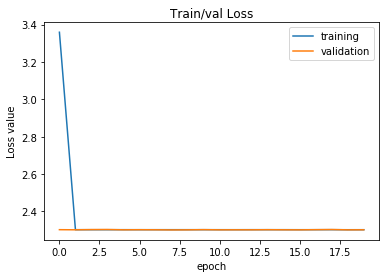

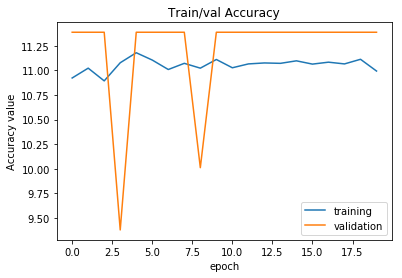

Hidden dim: 10, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.218 |            Val_acc: 11.400


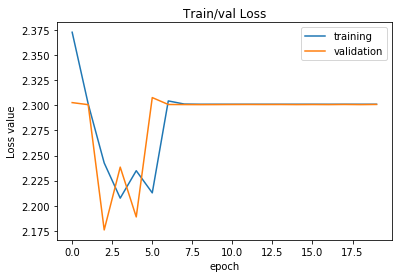

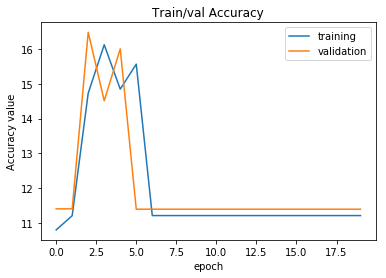

Hidden dim: 10, learning rate: 0.001
Train_loss: 1.009 |            Val_loss: 1.082 |            Train_acc: 64.818 |            Val_acc: 59.933


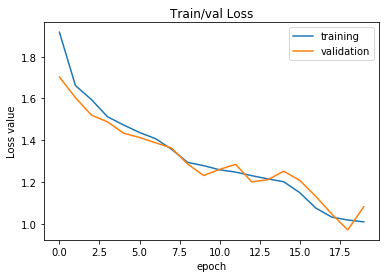

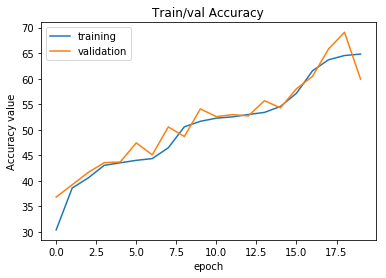

Hidden dim: 20, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.301 |            Train_acc: 11.108 |            Val_acc: 11.389


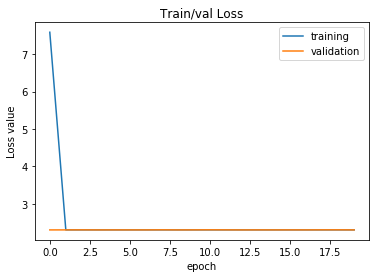

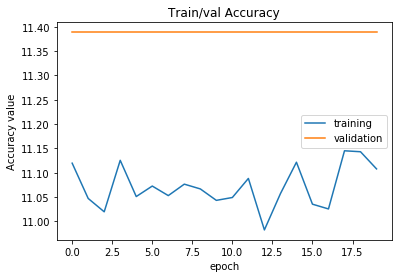

Hidden dim: 20, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.210 |            Val_acc: 11.389


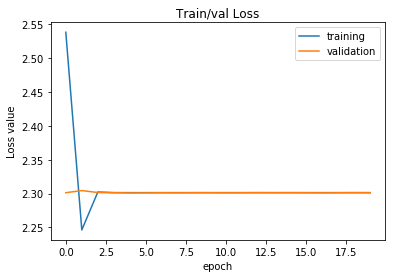

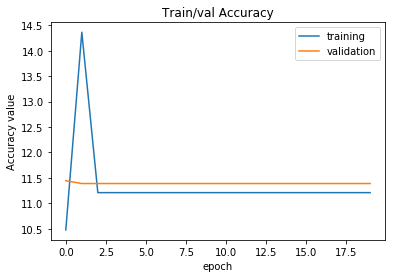

Hidden dim: 20, learning rate: 0.001
Train_loss: 0.274 |            Val_loss: 0.322 |            Train_acc: 92.129 |            Val_acc: 91.378


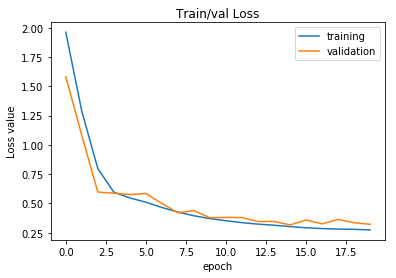

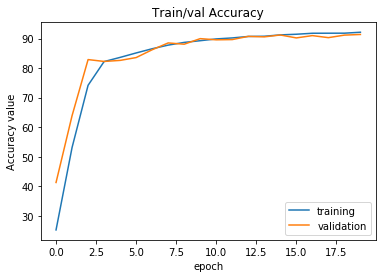

Hidden dim: 30, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.302 |            Train_acc: 11.098 |            Val_acc: 11.389


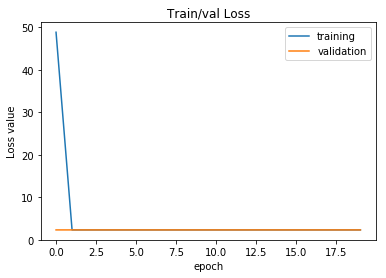

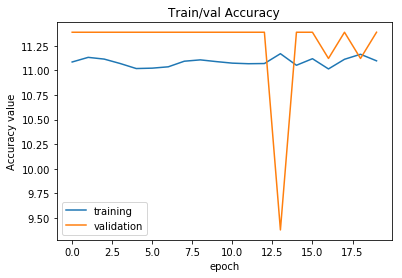

Hidden dim: 30, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.210 |            Val_acc: 11.389


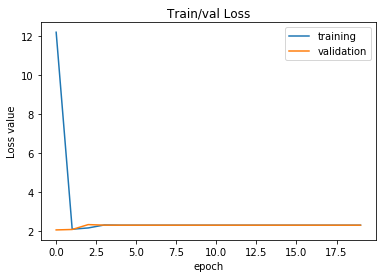

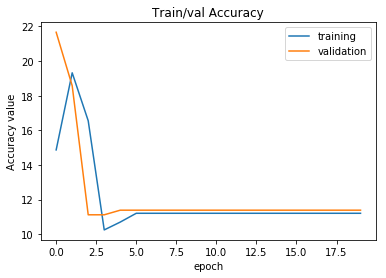

Hidden dim: 30, learning rate: 0.001
Train_loss: 0.132 |            Val_loss: 0.227 |            Train_acc: 96.025 |            Val_acc: 94.100


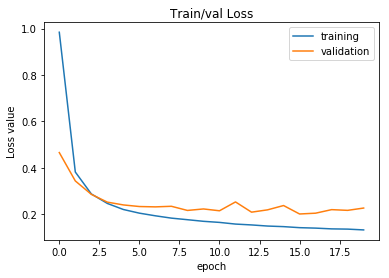

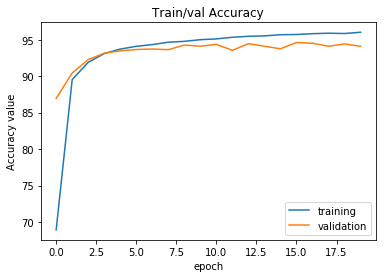

Hidden dim: 40, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.302 |            Train_acc: 11.018 |            Val_acc: 11.389


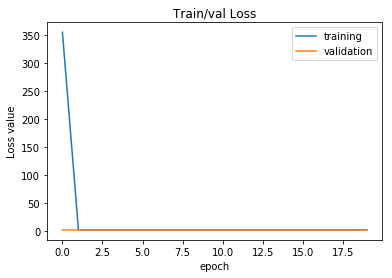

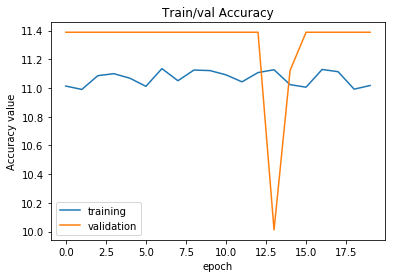

Hidden dim: 40, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.210 |            Val_acc: 11.389


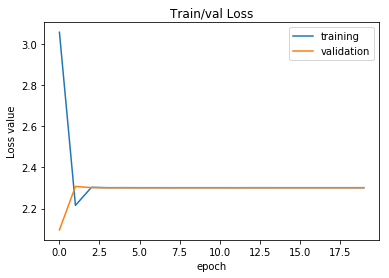

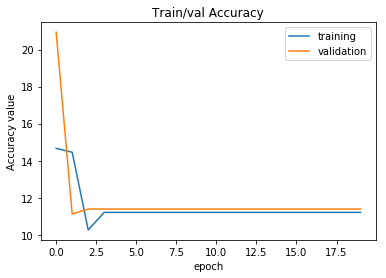

Hidden dim: 40, learning rate: 0.001
Train_loss: 0.127 |            Val_loss: 0.214 |            Train_acc: 96.141 |            Val_acc: 94.400


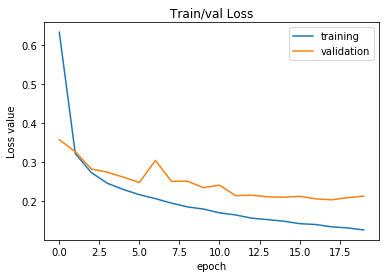

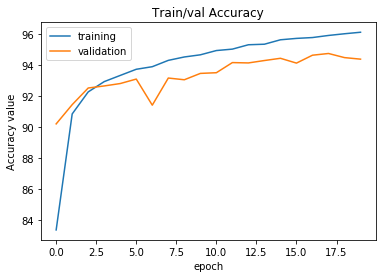

Hidden dim: 50, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.302 |            Train_acc: 11.076 |            Val_acc: 11.389


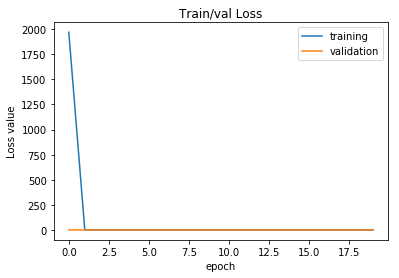

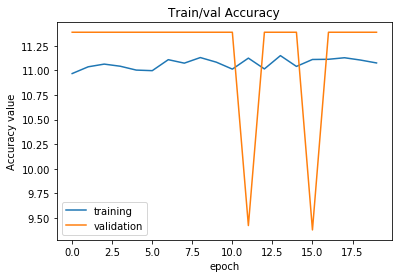

Hidden dim: 50, learning rate: 0.01
Train_loss: 1.880 |            Val_loss: 1.927 |            Train_acc: 26.067 |            Val_acc: 27.533


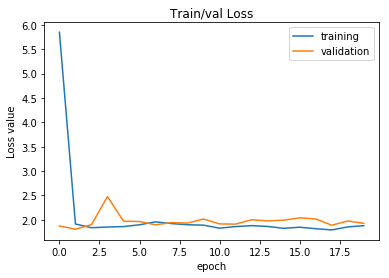

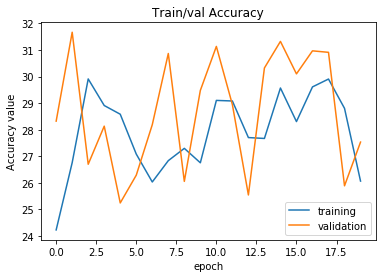

Hidden dim: 50, learning rate: 0.001
Train_loss: 0.092 |            Val_loss: 0.221 |            Train_acc: 97.135 |            Val_acc: 94.756


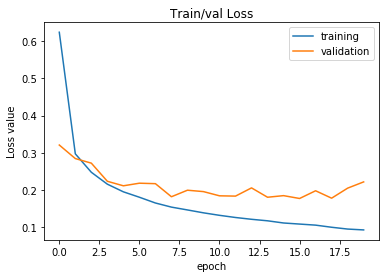

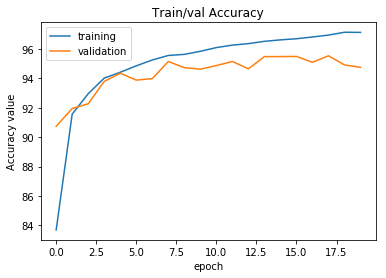

Hidden dim: 60, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.302 |            Train_acc: 11.086 |            Val_acc: 11.389


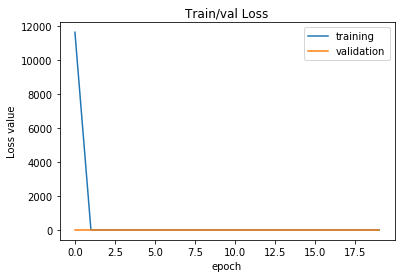

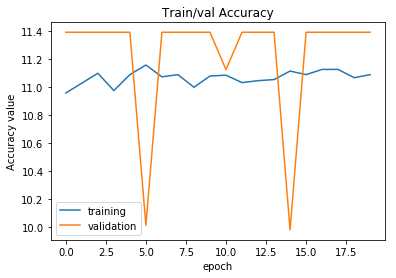

Hidden dim: 60, learning rate: 0.01
Train_loss: 2.150 |            Val_loss: 2.155 |            Train_acc: 16.220 |            Val_acc: 19.300


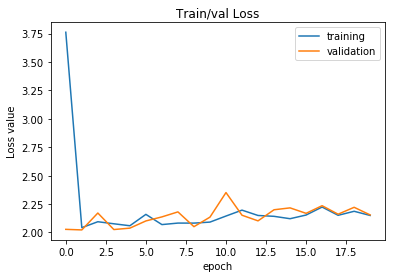

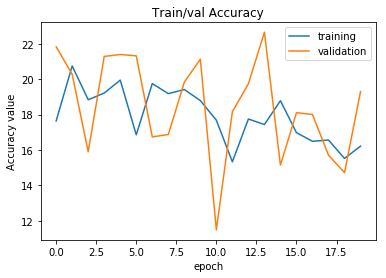

Hidden dim: 60, learning rate: 0.001
Train_loss: 0.064 |            Val_loss: 0.176 |            Train_acc: 98.025 |            Val_acc: 95.756


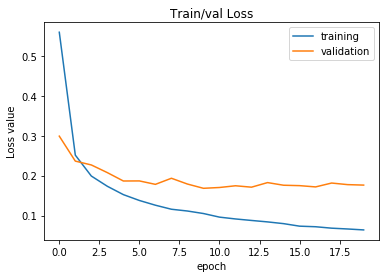

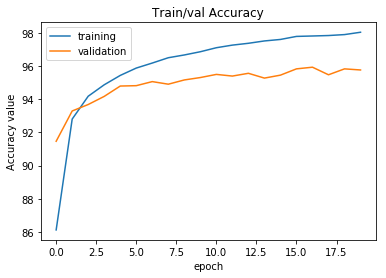

Hidden dim: 70, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.302 |            Train_acc: 11.098 |            Val_acc: 11.389


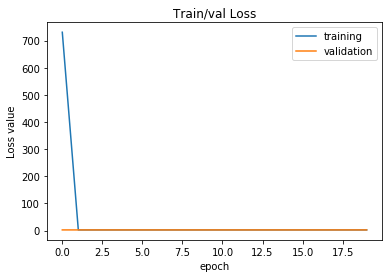

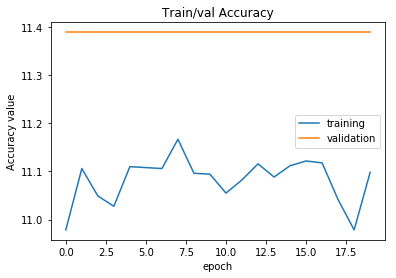

Hidden dim: 70, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.210 |            Val_acc: 11.389


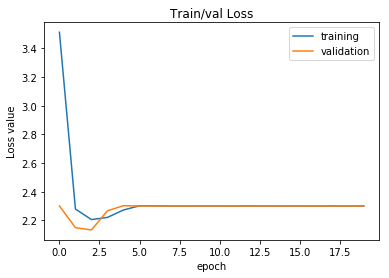

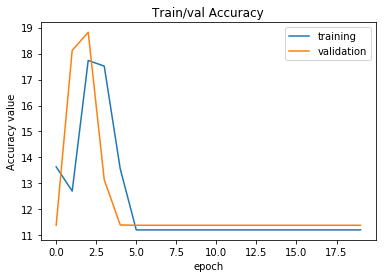

Hidden dim: 70, learning rate: 0.001
Train_loss: 0.064 |            Val_loss: 0.166 |            Train_acc: 97.916 |            Val_acc: 95.989


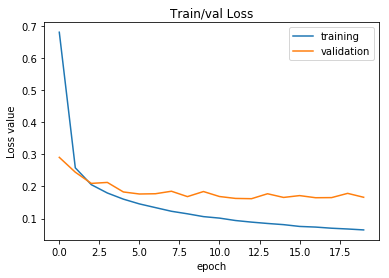

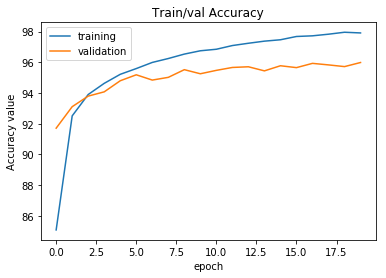

Hidden dim: 80, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.302 |            Train_acc: 11.108 |            Val_acc: 11.389


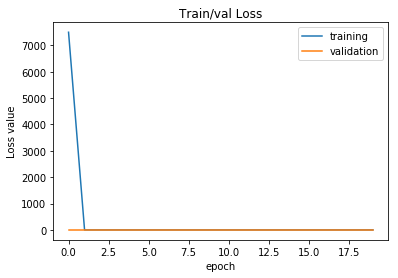

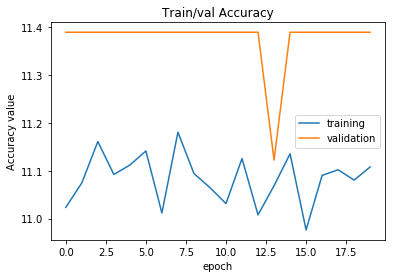

Hidden dim: 80, learning rate: 0.01
Train_loss: 2.067 |            Val_loss: 2.118 |            Train_acc: 19.592 |            Val_acc: 20.333


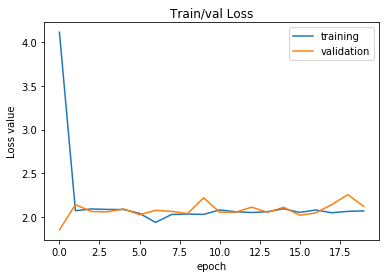

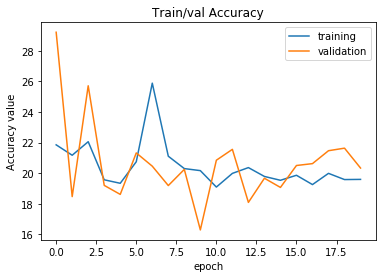

Hidden dim: 80, learning rate: 0.001
Train_loss: 0.042 |            Val_loss: 0.168 |            Train_acc: 98.651 |            Val_acc: 96.144


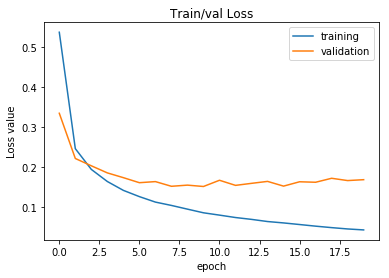

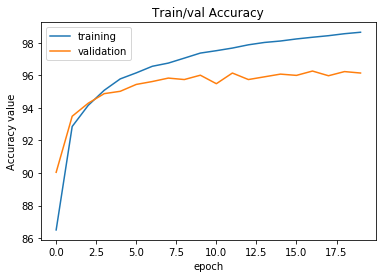

Hidden dim: 90, learning rate: 0.1
Train_loss: 2.300 |            Val_loss: 2.324 |            Train_acc: 11.178 |            Val_acc: 11.489


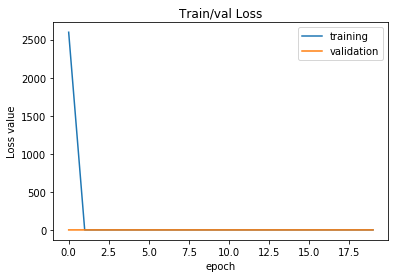

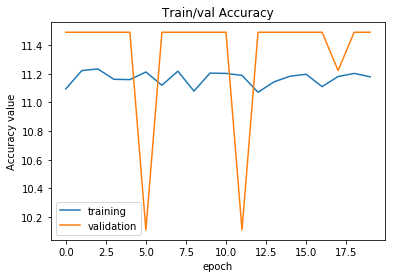

Hidden dim: 90, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.210 |            Val_acc: 11.389


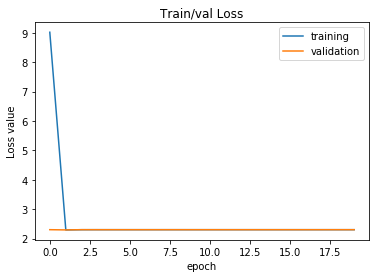

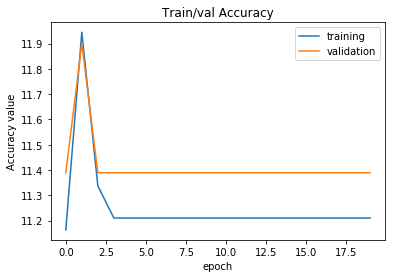

Hidden dim: 90, learning rate: 0.001
Train_loss: 0.033 |            Val_loss: 0.146 |            Train_acc: 99.002 |            Val_acc: 96.622


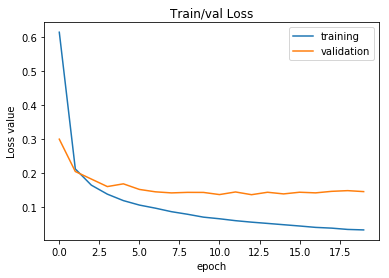

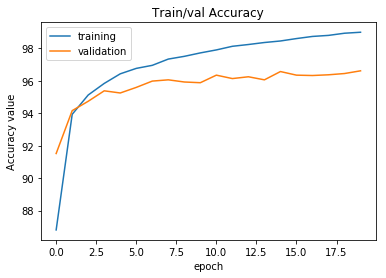

Hidden dim: 100, learning rate: 0.1
Train_loss: 2.302 |            Val_loss: 2.301 |            Train_acc: 11.196 |            Val_acc: 11.122


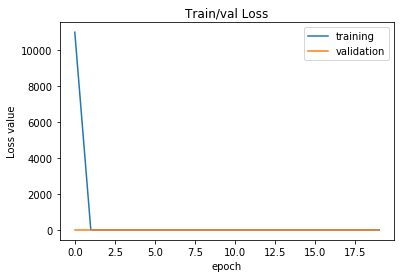

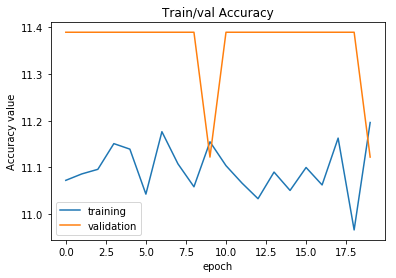

Hidden dim: 100, learning rate: 0.01
Train_loss: 2.301 |            Val_loss: 2.301 |            Train_acc: 11.210 |            Val_acc: 11.411


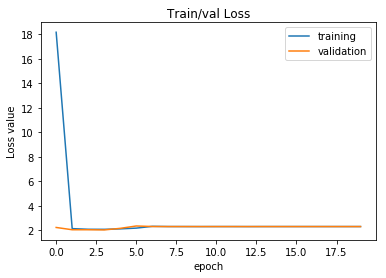

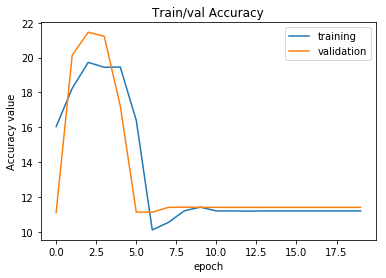

Hidden dim: 100, learning rate: 0.001
Train_loss: 0.044 |            Val_loss: 0.171 |            Train_acc: 98.612 |            Val_acc: 95.822


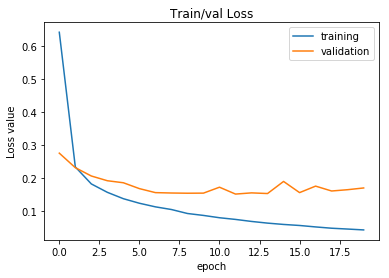

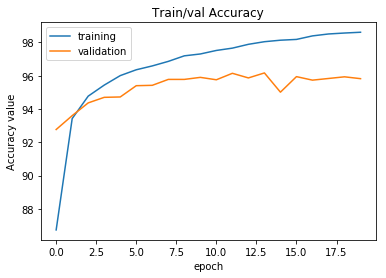

Best parameters: 90 hidden dim, 0.001 learning_rate and validation accuracies: 96.62%


In [11]:
input_dim = 28*28
hidden_dims = [i for i in range(10, 101, 10)]
output_dim = 10
nb_epochs = 20
l_rates = [1*10**-i for i in range(1, 4)]

# best parameters: (validation acc, hidden dim, learning rate)
best_parameters = (float("-INF"), None, None)

for hidden_dim, l_rate in product(hidden_dims, l_rates):
    neural_net = NeuralNetwork(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.SGD(neural_net.parameters(), l_rate)
    loss_function = nn.CrossEntropyLoss()
    
    print(f'Hidden dim: {hidden_dim}, learning rate: {l_rate}')
    val_acc = train_and_val(neural_net,
                            train_loader,
                            val_loader,
                            optimizer,
                            loss_function,
                            nb_epochs)
    
    if val_acc > best_parameters[0]:
        best_parameters = (val_acc, hidden_dim, l_rate)

best_acc, best_hidden_dim, best_l_rate = best_parameters
print(f'Best parameters: {best_hidden_dim} hidden dim, \
{best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

In [12]:
# Create dataset with full training set for the training the final model
train_full_dataset = MnistDataset(training_data, training_labels)
train_full_loader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=True)

# Train model with the best parameters
best_neural_net = NeuralNetwork(input_dim, best_hidden_dim, output_dim)
best_optimizer = torch.optim.SGD(best_neural_net.parameters(), best_l_rate)
loss_function = nn.CrossEntropyLoss()

for _ in range(nb_epochs):
    train(best_neural_net, train_full_loader, best_optimizer, loss_function)

In [15]:
loss_test, acc_test = validation(best_neural_net, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')

Accuracy on the test dataset 96.76%
